In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms

## Dataset


In [24]:
class CIFAR100Dataset():
    def __init__(self,batch_size = 256):
        self.transform = transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))
                        ])
        self.batch_size = batch_size
        self.train_set = datasets.CIFAR100("/",train=True, download=True, transform = self.transform)
        self.val_set = datasets.CIFAR100("/",train=False, download=True, transform = self.transform)

    def data_Loader(self,data_set,shuffle = True):
        return torch.utils.data.DataLoader(data_set, batch_size= self.batch_size, shuffle=shuffle)

    def get_train_loader(self):
        return self.data_Loader(self.train_set)

    def get_val_loader(self):
        return self.data_Loader(self.val_set)

## Models

In [25]:
import torch.nn as nn
class BasicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            
            nn.Linear(200,100),
        )

        
    def forward(self, x):
        x = self.layer(x)
        return x


In [39]:
import torch.nn.functional as F
class CNN(nn.Module):    
    def __init__(self):
        super().__init__() 
        
        #with a hidden layer, as feedforward - neural network
        self.linear1 = nn.Linear(3*32*32, 1536) #hidden layer
        self.linear2 = nn.Linear(1536, 100) #output layer
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        
        # Apply layers & activation functions  
        out = self.linear1(out)  
        out = F.relu(out)        
        out = self.linear2(out)  
        return out

## Train Model

In [43]:
def train(data,optimizer,model,n_epochs,loss_function):
    logs =[]
    losses = []
    val_accs =[]

    train_loader = data.get_train_loader()
    val_loader = data.get_val_loader()
    for epoch in range(1, n_epochs + 1):
        for i,batch in enumerate(train_loader):
            model.train()

            inputs, labels = batch
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs,labels)

            loss.backward()
            optimizer.step() #update parameters
        # val loop
        model.eval()
        true_preds = 0
        for batch in val_loader: 
            inputs, labels = batch
            with torch.no_grad():
                preds = model(inputs).argmax(dim=-1)
                true_preds += (preds == labels).sum().item()
        val_acc = true_preds/len(data.val_set)
        print('Epoch {}, Training loss {}, Val accuracy {}'.format(epoch, loss, val_acc))
        logs.append('Epoch {}, Training loss: {}, Val accuracy: {}'.format(epoch, loss, val_acc))
        losses.append(loss)
        val_accs.append(val_acc)

    # write logs
    with open('logs.txt', 'w') as f:
        for line in logs:
            f.write(line)
            f.write('\n')
    return losses,val_accs

In [44]:
model = CNN()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_epochs = 5

In [46]:
losses,val_accs = train(cifar100,optimizer,model,n_epochs,loss_function)

Epoch 1, Training loss 3.6358819007873535, Val accuracy 0.1786
Epoch 2, Training loss 3.095608949661255, Val accuracy 0.2021
Epoch 3, Training loss 3.3029208183288574, Val accuracy 0.2156
Epoch 4, Training loss 2.9315245151519775, Val accuracy 0.2281
Epoch 5, Training loss 3.0061278343200684, Val accuracy 0.2366


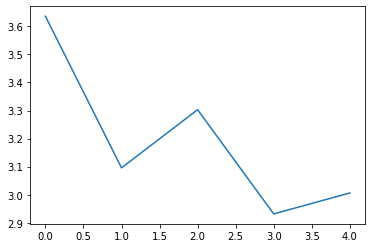

In [48]:
plt.plot(losses)

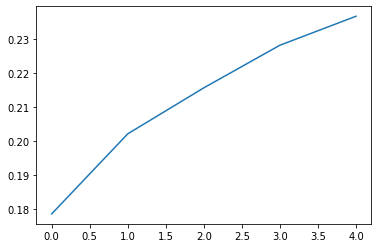

In [47]:
plt.plot(val_accs)